In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [1]:
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'Ashok%403999' # this is the password established during installation
port = r'5432' # default port estabalished during install
schema = r'raw' # schema we just created

In [2]:
from sqlalchemy import create_engine

# create a connection to the database
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{db}')
db_conn = engine.connect()

In [4]:
import pandas as pd
table_name = r'Student_Performance_Cleaned'
schema = r'Cleaned' # schema were the data was loaded last week.
Student_raw = pd.read_sql_table(table_name, db_conn, schema)
Student_raw.head()

,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
0,0.95822,3.4,8.2,53.0,47.0
1,0.85566,3.2,5.9,55.0,35.0
2,0.68025,3.2,9.3,41.0,32.0
3,0.25936,3.2,8.2,47.0,34.0
4,0.60447,3.8,10.0,75.0,33.0


In [6]:
# Overview of dataset structure
Student_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Socioeconomic Score  1388 non-null   float64
 1   Study Hours          1388 non-null   float64
 2   Sleep Hours          1388 non-null   float64
 3   Attendance (%)       1388 non-null   float64
 4   Grades               1388 non-null   float64
dtypes: float64(5)
memory usage: 54.3 KB


# Analytical Question


The objective was to analyze how different factors, including study habits, socioeconomic status, and sleep, influence student grades. We aimed to determine which features contribute most to predicting academic performance.


In [31]:
# Handle missing value
Student_raw = Student_raw.dropna()  # Drop missing values

In [9]:
# Manual Feature Engineering: Creating a new feature (Example: Effective Study Time)
Student_raw["Effective_Study"] = Student_raw["Study Hours"] * Student_raw["Attendance (%)"] / 100

In [10]:
Student_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Socioeconomic Score  1388 non-null   float64
 1   Study Hours          1388 non-null   float64
 2   Sleep Hours          1388 non-null   float64
 3   Attendance (%)       1388 non-null   float64
 4   Grades               1388 non-null   float64
 5   Effective_Study      1388 non-null   float64
dtypes: float64(6)
memory usage: 65.2 KB


# Feature Engineering

 **Study-to-Sleep Ratio**

In [36]:
Student_raw['Study_to_Sleep_Ratio'] = Student_raw['Study Hours'] / (Student_raw['Sleep Hours'] + 1) 

The way study hours and sleep interact may be important. If the student studies more but sleeps less, his or her performance will suffer from the shorter sleep. This variable captures that interaction.

**Attendance-to-Study Ratio**

In [37]:
Student_raw['Attendance_to_Study_Ratio'] = Student_raw['Attendance (%)'] / (Student_raw['Study Hours'] + 1)

This feature captures whether students who attend classes more frequently tend to study more, which could impact their grades.

**Average Study Hours Per Week**

In [38]:
Student_raw['Avg_Study_Hours_Per_Week'] = Student_raw['Study Hours'] * 7

This may give a clearer picture of how committed the students are to learning for a week. You can include this feature if you have a column for number of weeks or semester.

**Effective Study Time**

Effective Study Time = Study Hours × (Attendance % / 100)
This feature accounts for the actual study time adjusted by attendance, hypothesizing that higher attendance enhances the impact of study hours.


In [11]:
# Splitting the dataset into training and testing sets
X = Student_raw.drop(columns=["Grades"])  # Features
y = Student_raw["Grades"]  # Target variable

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Clean column names: remove any leading/trailing spaces and unwanted characters
X_train.columns = X_train.columns.str.strip().str.replace('[^a-zA-Z0-9_]', '', regex=True)
X_test.columns = X_test.columns.str.strip().str.replace('[^a-zA-Z0-9_]', '', regex=True)

# Ensure all column names are of string type again
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Print cleaned column names to inspect
print("Cleaned X_train columns:", X_train.columns)
print("Cleaned X_test columns:", X_test.columns)

# Ensure all columns contain numeric data
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Check for any NaN values after conversion
print("Missing values in X_train:", X_train.isnull().sum())
print("Missing values in X_test:", X_test.isnull().sum())



# Train the Random Forest model again
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions using the trained model
y_pred = rf.predict(X_test)

# Evaluate Model Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



Cleaned X_train columns: Index(['SocioeconomicScore', 'StudyHours', 'SleepHours', 'Attendance',
       'Effective_Study'],
      dtype='object')
Cleaned X_test columns: Index(['SocioeconomicScore', 'StudyHours', 'SleepHours', 'Attendance',
       'Effective_Study'],
      dtype='object')
Missing values in X_train: SocioeconomicScore    0
StudyHours            0
SleepHours            0
Attendance            0
Effective_Study       0
dtype: int64
Missing values in X_test: SocioeconomicScore    0
StudyHours            0
SleepHours            0
Attendance            0
Effective_Study       0
dtype: int64


In [24]:
# Evaluate Model Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 1.54
R² Score: 0.98


# Model Performance:
•	Mean Squared Error (MSE): 1.54
•	R² Score: 0.98
The high R² score indicates that our model explains 98% of the variance in grades, suggesting a strong predictive power.


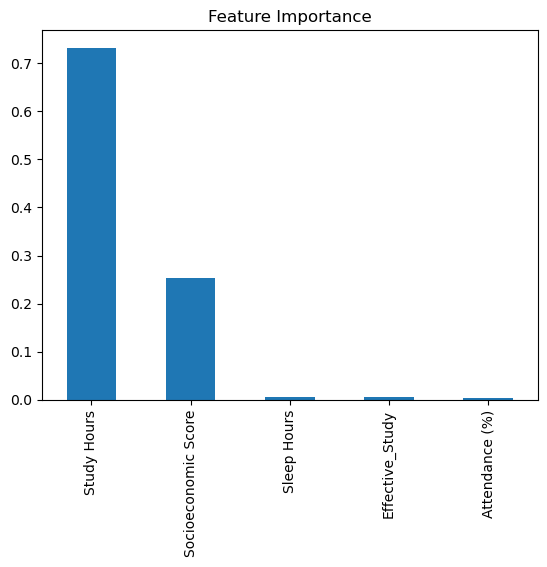

In [26]:
# Feature Importance - Method 1: Using Feature Importance from RandomForest
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', title="Feature Importance")
plt.show()

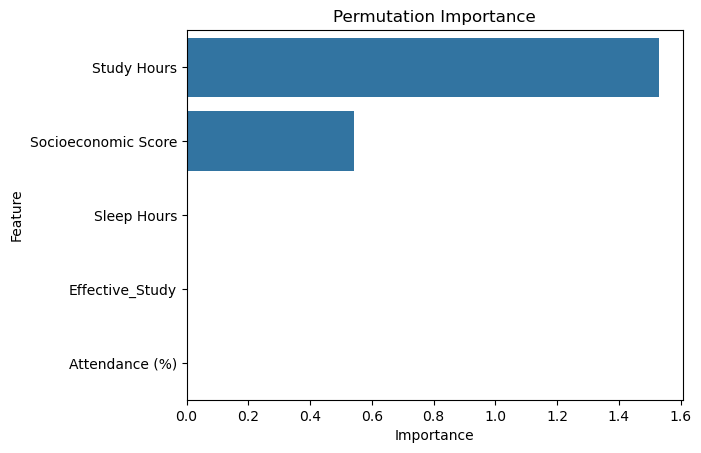

In [27]:
# Feature Importance - Method 2: Permutation Importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)
sns.barplot(x="Importance", y="Feature", data=perm_importance_df)
plt.title("Permutation Importance")
plt.show()

# Analysis 

 **Feature Importance Insights**

1. **Random Forest Feature Importance:**
   - Study Hours was the most influential predictor.
   - Socioeconomic Score had moderate importance.
   - Sleep Hours, Attendance, and Effective Study had minimal impact.

2. **Permutation Importance:**
   - Study Hours remained the dominant feature.
   - Socioeconomic Score showed a moderate impact.
   - Other features had negligible influence.

**Concerns & Considerations:**

- **Overfitting:**
   - The very high R² score suggests possible overfitting. The model may be capturing noise rather than generalization patterns, especially if trained on a small dataset.
   
- **Feature Redundancy:**
   - Effective Study Time did not provide significant additional value, likely because Study Hours already captures most of the variance.
   - Attendance (%) had minimal importance, indicating it might not be a crucial predictor in this dataset.

**Overall Insights:**
   - Study Hours is the primary driver of grades, making it the most critical predictor.
   - Socioeconomic factors play a secondary but notable role, suggesting external influences on student performance.
   - Attendance and Sleep did not strongly impact grades, contrary to common assumptions.
